# Churn Model

## EDA and Data Prep

#### Importing needed libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### Load dataset

In [2]:
df_origin = pd.read_csv('./data/churn.csv',sep=',')

#### Viewing dataset head

In [3]:
df_churn_all = df_origin
df_churn_all.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Viewing dataset info

In [4]:
df_churn_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


As per the info() output, there is no null values in the dataset. Also there are some object (string) values that have to be converted to number for using with decision tree algorithms

#### Checking if dataset is balanced

In [5]:
df_churn_all.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

As per the results above, the dataset is unbalanced and there are 80% of non-churn against 20% of churn samples. This might be an issue for the models. If so, we could apply oversampling as undersampling would reduce the data even more.

#### Converting string to numeric

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
cat_colums = df_churn_all.dtypes.pipe(lambda df_churn_all: df_churn_all[df_churn_all=='object']).index
for col in cat_colums:
    label = LabelEncoder()
    df_churn_all[col] = label.fit_transform(df_churn_all[col])

In [8]:
df_churn_all.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,1115,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,1177,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,2040,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,289,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,1822,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [9]:
df_churn_all.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

<AxesSubplot:>

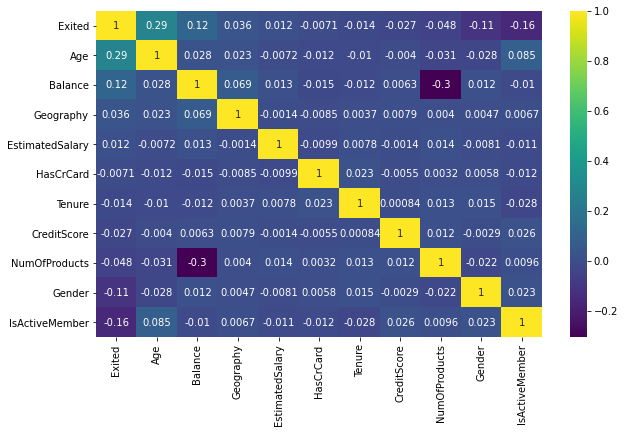

In [10]:
k = 11 #number of variables for heatmap
cols = df_churn_all.corr().nlargest(k, 'Exited')['Exited'].index
cm = df_churn_all[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

We can see the highest positive correlation between Age and the target class Exited, followed by Balance and a negative correlation with Gender. We can also see a inter-correlation between NumOfProducts and Balance (negative correlation).

#### Age

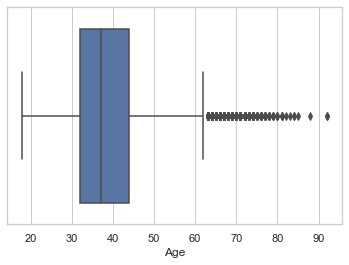

In [11]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_churn_all["Age"])

In [12]:
df_churn_all = df_churn_all[df_churn_all['Age'] < 63]

In [13]:
df_churn = df_churn_all.loc[df_churn_all["Exited"]==1]
df_not_churn = df_churn_all.loc[df_churn_all["Exited"]==0]

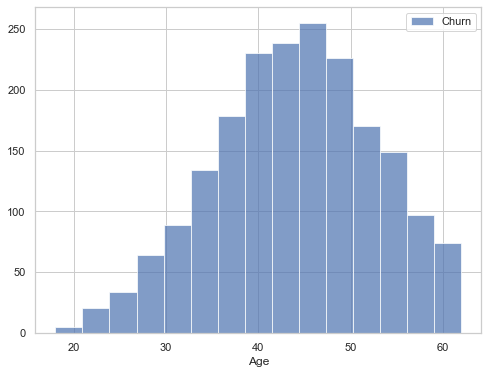

In [14]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(df_churn["Age"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

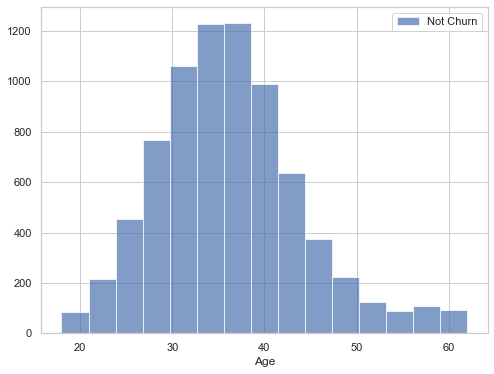

In [15]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(df_not_churn["Age"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

From the 2 plots above, we can conclude the older the person is, the more likely to churn. For instance, we can see approximately the same number of churn and not churn above 50 years old

In [16]:
bins= [20,30,40,50,60,70,80,90]
labels = ['20','30','40','50','60','70','80']
df_churn_all['AgeGroup'] = pd.cut(df_churn_all['Age'], bins=bins, labels=labels, right=False)

In [17]:
# Filter out columns of our interest
df_1 = df_churn_all.loc[:, ['AgeGroup', 'Exited']]
   
# Group the data
groupby = df_1.groupby("AgeGroup", axis=0).count().reset_index()
groupby2 = df_1.groupby("AgeGroup", axis=0).sum().reset_index()
groupby2.rename({'Exited':'Churned'},axis=1,inplace=True)
frames = [groupby,groupby2.drop(['AgeGroup'],axis=1)]
result = pd.concat(frames,axis=1)

result['Percentage'] = ( result['Churned'] / result['Exited'] ) * 100
result


,AgeGroup,Exited,Churned,Percentage
0,20,1592,121,7.600503
1,30,4346,473,10.883571
2,40,2618,806,30.786860
3,50,869,487,56.041427
4,60,167,74,44.311377
5,70,0,0,NaN
6,80,0,0,NaN


[Text(0.5, 0, 'Age'), Text(0, 0.5, 'Churn %')]

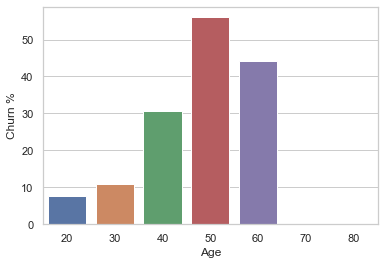

In [18]:
ax = sns.barplot(x='AgeGroup',y='Percentage',data=result)
ax.set(xlabel='Age',ylabel='Churn %')

From the numbers and graph above, we can notice that churn rates increase considerably in the range from 40 to 60 years (representing almost 40% of the customers), varying from 30% to 56%. This is an important information that should be take in consideration for further analysis.

#### Balance

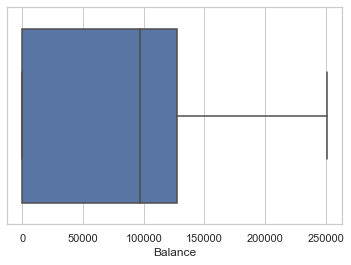

In [19]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_churn_all["Balance"])

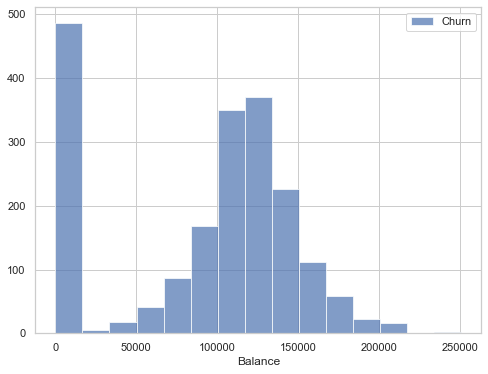

In [20]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Balance')
pyplot.hist(df_churn["Balance"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

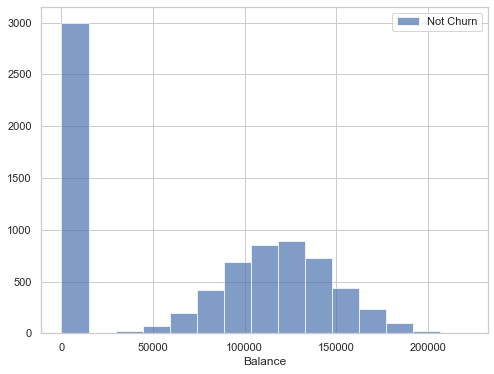

In [21]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Balance')
pyplot.hist(df_not_churn["Balance"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [22]:
bins= [0,25000,50000,75000,100000,125000,150000,175000,200000]
labels = ['0','25000','50000','75000','100000','125000','150000','175000']
df_churn_all['BalanceGroup'] = pd.cut(df_churn_all['Balance'], bins=bins, labels=labels, right=False)

In [23]:
# Filter out columns of our interest
df_1 = df_churn_all.loc[:, ['BalanceGroup', 'Exited']]
   
# Group the data
groupby = df_1.groupby("BalanceGroup", axis=0).count().reset_index()
groupby2 = df_1.groupby("BalanceGroup", axis=0).sum().reset_index()
groupby2.rename({'Exited':'Churned'},axis=1,inplace=True)
frames = [groupby,groupby2.drop(['BalanceGroup'],axis=1)]
result = pd.concat(frames,axis=1)

result['Percentage'] = ( result['Churned'] / result['Exited'] ) * 100
result


,BalanceGroup,Exited,Churned,Percentage
0,0,3489,489,14.015477
1,25000,64,20,31.250000
2,50000,335,71,21.194030
3,75000,1121,218,19.446922
4,100000,1996,538,26.953908
5,125000,1697,410,24.160283
6,150000,715,151,21.118881
7,175000,190,48,25.263158


Here we can see that churn rate percentage is distributed across the groups of different balances. This corresponds to the lower correlation of this feature comparing to Age.

#### Gender

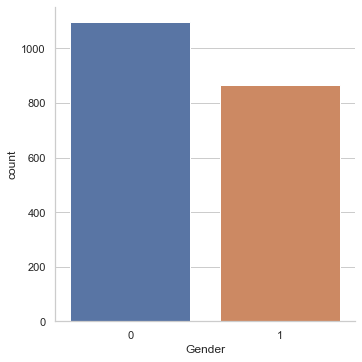

In [24]:
sns.catplot(x="Gender", kind="count", data=df_churn)

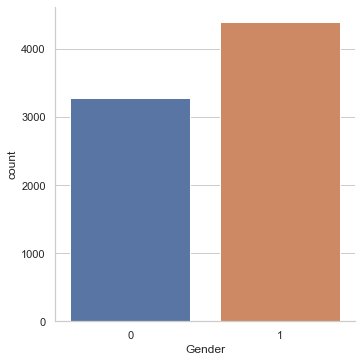

In [25]:
sns.catplot(x="Gender", kind="count", data=df_not_churn)

In [26]:
FemaleCount = len(df_churn_all[df_churn_all['Gender'] == 0])
FemaleChurn = len(df_churn[df_churn['Gender'] == 0])
print(f"Female total count:{(FemaleCount)}")
print(f"Female churn percentage:{(FemaleChurn/FemaleCount)*100}")

Female total count:4376
Female churn percentage:25.09140767824497


In [27]:
MaleCount = len(df_churn_all[df_churn_all['Gender'] == 1])
MaleChurn = len(df_churn[df_churn['Gender'] == 1])
print(f"Male total count:{(MaleCount)}")
print(f"Male churn percentage:{(MaleChurn/MaleCount)*100}")

Male total count:5265
Male churn percentage:16.44824311490978


While analyzing Gender, we conclude that Females (which represents 45% of the customers) have a high churn rate (25%) comparing to Males (16.5%). This is another information that could be investigated further.

## Modeling

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import scikitplot as skplt

### Auxiliary functions

In [29]:
def scale(dataset):
    scale = StandardScaler().fit(dataset)
    X_train_scaled = scale.transform(dataset)
    
    return X_train_scaled

In [30]:
def importance(importances, columns):
    l = len(columns)
    for i in range(0,len(columns)-1):
        print('{:.<20} {:3}'.format(columns[i],importances[i]))

### Bayesian Tuning

In [31]:
def bayesian_tuning(estimator, search_space, Xtrain, ytrain):

    opt = BayesSearchCV(
        estimator=estimator,
        search_spaces=search_space,
        n_iter=30,
        cv=5
    )

    opt.fit(Xtrain, ytrain)

    print("val. score: %s" % opt.best_score_)
    print("test score: %s" % opt.score(X_test, y_test))
    print("best params: %s" % str(opt.best_params_))

### Logistic Regression

In [32]:
df_churn_all.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,BalanceGroup
0,619,0,0,42,2,0.00,1,1,1,101348.88,1,40,0
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0,40,75000
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1,40,150000
3,699,0,0,39,1,0.00,2,0,0,93826.63,0,30,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0,40,125000


In [33]:
df_churn_feat = df_churn_all.drop(['Exited','AgeGroup','BalanceGroup'],axis=1)

In [34]:
df_churn_feat.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10


In [35]:
df_churn_target = df_churn_all['Exited']

In [36]:
df_churn_target.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_churn_feat,df_churn_target,test_size=0.3)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6748, 10), (2893, 10), (6748,), (2893,))

In [39]:
C_param_range = [0.001,0.01,0.1,1,10,100]

params = {'clf__C': C_param_range}

In [40]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(C = 1))])

bayesian_tuning(pipe, params, X_train, y_train)

val. score: 0.8246887966804979
test score: 0.8091946076736951
best params: OrderedDict([('clf__C', 1.0)])


In [41]:
lr = LogisticRegression(penalty='l2',C=1,random_state=0)
lr.fit(scale(X_train), y_train)

LogisticRegression(C=1, random_state=0)

In [46]:
result_lr = lr.predict(scale(X_test))

In [47]:
accuracy_score(y_test, result_lr)

0.8085032837884549

In [49]:
print(classification_report(y_test,result_lr))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      2299
           1       0.58      0.24      0.34       594

    accuracy                           0.81      2893
   macro avg       0.71      0.60      0.62      2893
weighted avg       0.78      0.81      0.78      2893



In [61]:
df_confusion = pd.crosstab(y_test, result_lr, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,2194,105,2299
1,449,145,594
All,2643,250,2893


#### Generating Synthetic Samples with SMOTE

In [62]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)

In [63]:
X = X_train
y = y_train

In [64]:
X, y = over.fit_resample(X, y)
X, y = under.fit_resample(X, y)

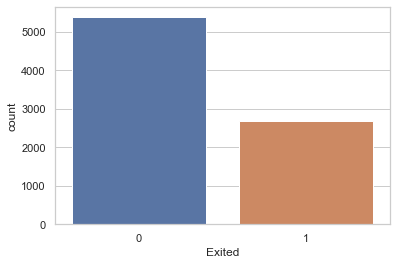

In [65]:
ax = sns.countplot(x='Exited',data=y.to_frame())

In [66]:
y.value_counts()

0    5378
1    2689
Name: Exited, dtype: int64

In [67]:
X_train_syn, y_train_syn = X, y

In [68]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(C = 1))])

bayesian_tuning(pipe, params, X_train_syn, y_train_syn)

val. score: 0.783686624519648
test score: 0.7849982716902869
best params: OrderedDict([('clf__C', 10.0)])


In [69]:
lr = LogisticRegression(penalty='l2',C=10,random_state=0)
lr.fit(scale(X_train_syn), y_train_syn)

LogisticRegression(C=10, random_state=0)

In [70]:
result_lr = lr.predict(scale(X_test))

In [71]:
accuracy_score(y_test, result_lr)

0.7628759073625994

In [72]:
print(classification_report(y_test,result_lr))

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      2299
           1       0.44      0.53      0.48       594

    accuracy                           0.76      2893
   macro avg       0.65      0.68      0.66      2893
weighted avg       0.78      0.76      0.77      2893



In [73]:
df_confusion = pd.crosstab(y_test, result_lr, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,1893,406,2299
1,280,314,594
All,2173,720,2893


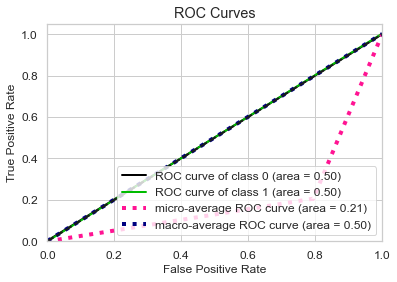

In [74]:
y_probas = lr.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_probas, cmap='nipy_spectral')
plt.show()

### Naive Bayes

In [77]:
from sklearn.naive_bayes import GaussianNB

In [78]:
params = {'clf__var_smoothing': np.logspace(0,-9,num=100)}

In [79]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', GaussianNB(var_smoothing = np.logspace(0,-9,num=100)))])

bayesian_tuning(pipe, params, X_train_syn, y_train_syn)

val. score: 0.7984380810710301
test score: 0.8012443829934324
best params: OrderedDict([('clf__var_smoothing', 0.0008111308307896872)])


In [80]:
nb = GaussianNB(var_smoothing=0.0008111308307896872)
nb.fit(scale(X_train_syn), y_train_syn)

GaussianNB(var_smoothing=0.0008111308307896872)

In [81]:
result_nb = nb.predict(scale(X_test))

In [82]:
accuracy_score(y_test, result_nb)

0.7818873142067059

In [83]:
print(classification_report(y_test,result_nb))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      2299
           1       0.48      0.59      0.53       594

    accuracy                           0.78      2893
   macro avg       0.68      0.71      0.69      2893
weighted avg       0.80      0.78      0.79      2893



In [84]:
df_confusion = pd.crosstab(y_test, result_nb, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,1910,389,2299
1,242,352,594
All,2152,741,2893


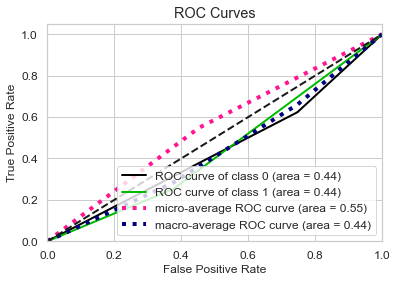

In [85]:
y_probas = nb.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_probas, cmap='nipy_spectral')
plt.show()

### Decision Tree

In [86]:
from sklearn.tree import DecisionTreeClassifier

In [87]:
params = {'clf__criterion': ('gini','entropy'),
          'clf__max_depth': (2,3,4,5,10,20,50,100),
          'clf__min_samples_split': (2,5,10,15,20),
          'clf__min_samples_leaf':(1,5,10,15,20)}

In [88]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', DecisionTreeClassifier())])

bayesian_tuning(pipe, params, X_train_syn, y_train_syn)

val. score: 0.8083550266517913
test score: 0.8102315935015555
best params: OrderedDict([('clf__criterion', 'gini'), ('clf__max_depth', 10), ('clf__min_samples_leaf', 20), ('clf__min_samples_split', 5)])


In [89]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=20, min_samples_split=5)
dt.fit(scale(X_train_syn), y_train_syn)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=5)

In [90]:
result_dt = dt.predict(scale(X_test))

In [91]:
accuracy_score(y_test, result_dt)

0.773591427583823

In [92]:
print(classification_report(y_test,result_dt))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2299
           1       0.46      0.63      0.53       594

    accuracy                           0.77      2893
   macro avg       0.68      0.72      0.69      2893
weighted avg       0.81      0.77      0.79      2893



In [93]:
df_confusion = pd.crosstab(y_test, result_dt, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,1866,433,2299
1,222,372,594
All,2088,805,2893


In [94]:
importance(dt.feature_importances_, X_train_syn.columns)

CreditScore......... 0.02673711053802434
Geography........... 0.04394074827540771
Gender.............. 0.06448282748748205
Age................. 0.39768199771218665
Tenure.............. 0.01523513819499359
Balance............. 0.06907410809954674
NumOfProducts....... 0.20515242399330125
HasCrCard........... 0.006830623292745241
IsActiveMember...... 0.1503570605881362


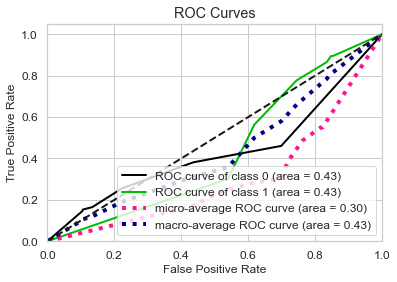

In [95]:
y_probas = dt.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_probas, cmap='nipy_spectral')
plt.show()

### Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
params = {'clf__n_estimators': (10,20,50,100),
          'clf__criterion': ('gini','entropy'),
          'clf__max_depth': (2,3,4,5,10,20,50,100),
          'clf__min_samples_split': (2,5,10,15,20),
          'clf__min_samples_leaf':(1,5,10,15,20)}

In [98]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', RandomForestClassifier())])

bayesian_tuning(pipe, params, X_train_syn, y_train_syn)

val. score: 0.833147390603694
test score: 0.832353957829243
best params: OrderedDict([('clf__criterion', 'entropy'), ('clf__max_depth', 100), ('clf__min_samples_leaf', 1), ('clf__min_samples_split', 2), ('clf__n_estimators', 100)])


In [99]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=100, min_samples_leaf=1, min_samples_split=2)
rf.fit(scale(X_train_syn), y_train_syn)

RandomForestClassifier(criterion='entropy', max_depth=100)

In [100]:
result_rf = rf.predict(scale(X_test))

In [101]:
accuracy_score(y_test, result_rf)

0.8326996197718631

In [102]:
print(classification_report(y_test,result_rf))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2299
           1       0.60      0.58      0.59       594

    accuracy                           0.83      2893
   macro avg       0.74      0.74      0.74      2893
weighted avg       0.83      0.83      0.83      2893



In [103]:
df_confusion = pd.crosstab(y_test, result_rf, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,2066,233,2299
1,251,343,594
All,2317,576,2893


In [104]:
importance(rf.feature_importances_, X_train_syn.columns)

CreditScore......... 0.13748793254820899
Geography........... 0.04225086407070182
Gender.............. 0.038798536647421854
Age................. 0.23228436876167247
Tenure.............. 0.08493305614335195
Balance............. 0.13428381678595347
NumOfProducts....... 0.10436020944233051
HasCrCard........... 0.020012661629175716
IsActiveMember...... 0.060528104538763915


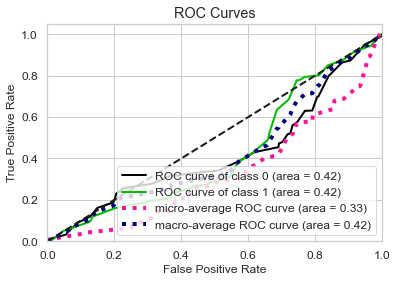

In [105]:
y_probas = rf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_probas, cmap='nipy_spectral')
plt.show()

### LightGBM

In [106]:
import lightgbm as lgb

In [107]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_syn, y_train_syn)

LGBMClassifier()

In [118]:
result_lgb = lgbm.predict(X_test)

In [119]:
accuracy_score(y_test, result_lgb)

0.835119253370204

In [120]:
print(classification_report(y_test,result_lgb))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2299
           1       0.61      0.55      0.58       594

    accuracy                           0.84      2893
   macro avg       0.75      0.73      0.74      2893
weighted avg       0.83      0.84      0.83      2893



In [121]:
df_confusion = pd.crosstab(y_test, result_lgb, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,2087,212,2299
1,265,329,594
All,2352,541,2893


In [112]:
importance(lgbm.feature_importances_, X_train_syn.columns)

CreditScore......... 483
Geography........... 153
Gender..............  99
Age................. 363
Tenure.............. 231
Balance............. 661
NumOfProducts....... 234
HasCrCard...........  71
IsActiveMember......  86


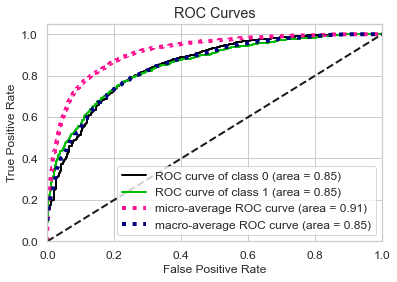

In [113]:
y_probas = lgbm.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_probas, cmap='nipy_spectral')
plt.show()

In [122]:
pd_proba = pd.DataFrame(lgbm.predict_proba(X_test), columns=lgbm.classes_)

In [123]:
pd_proba[(pd_proba[1] > 0.79999)]

,0,1
23,0.142930,0.857070
27,0.107166,0.892834
30,0.073092,0.926908
37,0.060994,0.939006
58,0.092056,0.907944
...,...,...
2816,0.007859,0.992141
2818,0.031045,0.968955
2832,0.021023,0.978977
2865,0.037467,0.962533
